# Deconvolve Simulated Sigmoid data

In [1]:
import torch
from time_deconv.time_deconv import *
from time_deconv.time_deconv_simulator import *

# Configuration

In [2]:
device = torch.device("cuda:0")
dtype = torch.float32
dtype_np = np.float32

# Load data

In [3]:
bulk_anndata_path = "/home/nbarkas/disk2/deconvolution_method/datasets/ebov/load_data_python/ebov_bulk.h5ad"
sc_anndata_path = "/home/nbarkas/disk2/deconvolution_method/datasets/ebov/load_data_python/ebov_sc.h5ad"

In [4]:
with open(bulk_anndata_path, 'rb') as fh:
    bulk_anndata  = anndata.read_h5ad(fh)
with open(sc_anndata_path, 'rb') as fh:
    sc_anndata = anndata.read_h5ad(fh)

In [5]:
# select samples only after or on tp 0
bulk_anndata = bulk_anndata[bulk_anndata.obs['dpi_time'] >= 0,]

In [6]:
bulk_anndata.shape

(52, 12180)

In [7]:
ebov_dataset = DeconvolutionDataset(
    sc_anndata = sc_anndata,
    sc_celltype_col = "Subclustering_reduced",
    bulk_anndata = bulk_anndata,
    bulk_time_col = "dpi_time",
    dtype_np = dtype_np,
    dtype = dtype,
    device=device,
    feature_selection_method = 'overdispersed_bulk_and_high_sc' #'overdispersed_bulk'
)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=3.1044e-10): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T


# Run Deconvolution

In [8]:
pseudo_time_reg_deconv = TimeRegularizedDeconvolution(
    dataset=ebov_dataset,
    polynomial_degree = 5,
    basis_functions = "polynomial",
    device=device,
    dtype=dtype)

In [9]:
pseudo_time_reg_deconv.fit_model(n_iters=1_000, verbose=True, log_frequency=1000)

[iteration: 0]   loss: 30368141.04


# Examine Outputs

<AxesSubplot:title={'center':'Losses'}, xlabel='iteration', ylabel='ELBO Loss'>

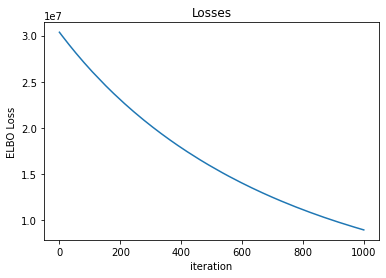

In [10]:
pseudo_time_reg_deconv.plot_loss()

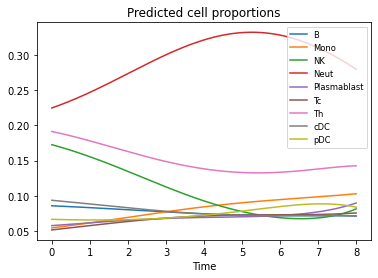

In [11]:
# calculate and plot composition trajectories
pseudo_time_reg_deconv.calculate_composition_trajectories(n_intervals = 1000)
pseudo_time_reg_deconv.plot_composition_trajectories()

<AxesSubplot:xlabel='$\\phi_g$', ylabel='Counts'>

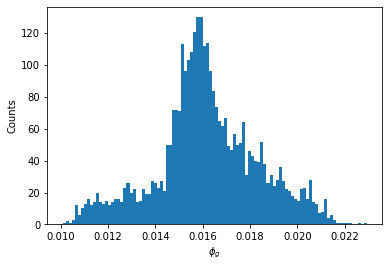

In [12]:
# examine the per-gene dispersions
pseudo_time_reg_deconv.plot_phi_g_distribution()

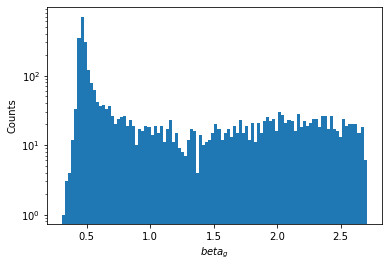

In [13]:
# examine the gene capture coefficients
pseudo_time_reg_deconv.plot_beta_g_distribution()
matplotlib.pyplot.yscale('log')

# Simulation

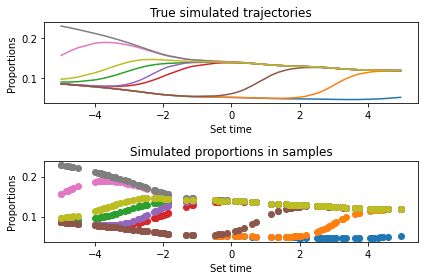

In [36]:
# Simulate and plot proportions
sim_res = simulate_data(
    num_samples=100, 
    reference_deconvolution=pseudo_time_reg_deconv,
    dirichlet_alpha = 1e10,
    trajectory_type = 'sigmoid',
    trajectory_sample_params = {
        'effect_size_min': -1,
        'effect_size_max': 1,
        'shift_min': 10,
        'shift_max': 30,
    }
)

plot_simulated_proportions(sim_res)
matplotlib.pyplot.tight_layout()
matplotlib.pyplot.show()

In [15]:
simulated_bulk = generate_anndata_from_sim(
    sim_res, 
    reference_deconvolution=pseudo_time_reg_deconv
)

ebov_simulated_dataset = DeconvolutionDataset(
    sc_anndata = sc_anndata,
    sc_celltype_col = "Subclustering_reduced",
    bulk_anndata = simulated_bulk,
    bulk_time_col = "time",
    dtype_np = dtype_np,
    dtype = dtype,
    device = device,
    feature_selection_method = 'common' 
)

/opt/conda/lib/python3.7/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [ ]:
pseudo_time_reg_deconv_sim = TimeRegularizedDeconvolution(
    dataset=ebov_simulated_dataset,
    polynomial_degree = 5,
    basis_functions = "polynomial",
    device=device,
    dtype=dtype)

pseudo_time_reg_deconv_sim.fit_model(
    n_iters=5_001, 
    verbose=True, 
    log_frequency=1000)

[iteration: 0]   loss: 1372161.04
[iteration: 1000]   loss: 1324229.96


In [ ]:
# Examine Outputs

In [ ]:
pseudo_time_reg_deconv_sim.plot_loss()

In [ ]:
pseudo_time_reg_deconv_sim.calculate_composition_trajectories(n_intervals = 1000)
plot_simulated_proportions(sim_res)
matplotlib.pyplot.show()

In [ ]:
# calculate and plot composition trajectories
pseudo_time_reg_deconv.calculate_composition_trajectories(n_intervals = 1000)
pseudo_time_reg_deconv.plot_composition_trajectories()

In [ ]:
# examine the per-gene dispersions
pseudo_time_reg_deconv.plot_phi_g_distribution()

In [ ]:
# examine the gene capture coefficients
pseudo_time_reg_deconv.plot_beta_g_distribution()
matplotlib.pyplot.yscale('log')

In [ ]:
# examine the alphas

alphas = list(pseudo_time_reg_deconv.param_store_hist[i]['dirichlet_alpha'] for i in range(len(pseudo_time_reg_deconv.param_store_hist)))

fig, ax = matplotlib.pyplot.subplots(1,2)

ax[0].plot(alphas)
ax[0].set_title(r'Dirichlet $ \alpha $ Values')

ax[1].plot(alphas[-500:])
ax[1].set_title(r'Last few Dirichlet $ \alpha $ Values')